In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [30]:
np.random.seed(0)
n = 300

age = np.random.normal(60, 12, n)
severity = np.random.gamma(shape=2, scale=3, size=n)
hr = 70 + 2*severity + np.random.normal(0, 5, n)

sbp = 140 - 1.2*age - 3*severity + np.random.normal(0, 10, n)

df = pd.DataFrame({
    "Age": age,
    "Severity": severity,
    "HeartRate": hr,
    "SBP": sbp
})

df_miss = df.copy()

In [31]:
# Artficially introducing Missing data

prob_missing = 1 / (1 + np.exp((df_miss["SBP"] - 110)/5))
missing_mask = np.random.rand(n) < prob_missing * 0.6
df_miss.loc[missing_mask, "SBP"] = np.nan

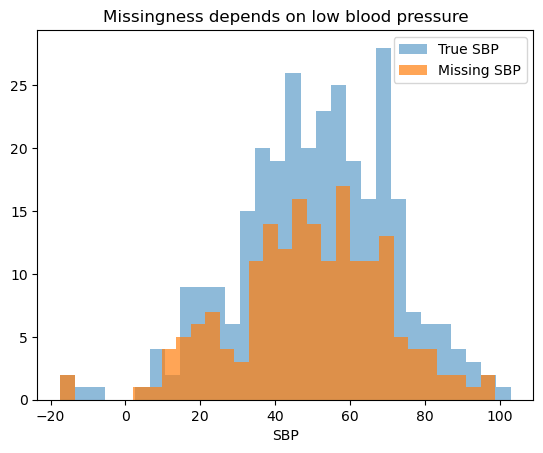

In [32]:
plt.figure()
plt.hist(sbp, bins=30, alpha=0.5, label="True SBP")
plt.hist(sbp[missing_mask], bins=30, alpha=0.7, label="Missing SBP")
plt.legend()
plt.title("Missingness depends on low blood pressure")
plt.xlabel("SBP")
plt.show()

In [22]:
mean_imp = SimpleImputer(strategy="mean")
df_mean = df_miss.copy()
df_mean["SBP_imp"] = mean_imp.fit_transform(df_miss[["SBP"]])

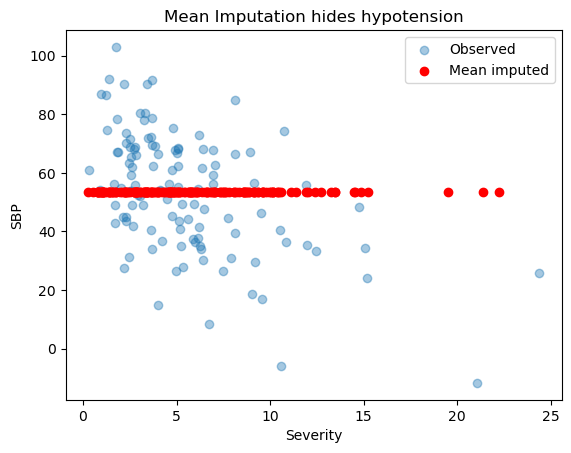

In [23]:
plt.figure()
plt.scatter(df_miss["Severity"], df_miss["SBP"], alpha=0.4, label="Observed")
plt.scatter(df_miss.loc[missing_mask, "Severity"],
            df_mean.loc[missing_mask, "SBP_imp"],
            color="red", label="Mean imputed")
plt.xlabel("Severity")
plt.ylabel("SBP")
plt.legend()
plt.title("Mean Imputation hides hypotension")
plt.show()

In [24]:
obs = df_miss.dropna()
miss = df_miss[df_miss["SBP"].isna()]

lr = LinearRegression()
lr.fit(obs[["Age", "Severity", "HeartRate"]], obs["SBP"])

df_reg = df_miss.copy()
df_reg.loc[missing_mask, "SBP_imp"] = lr.predict(
    miss[["Age", "Severity", "HeartRate"]]
)

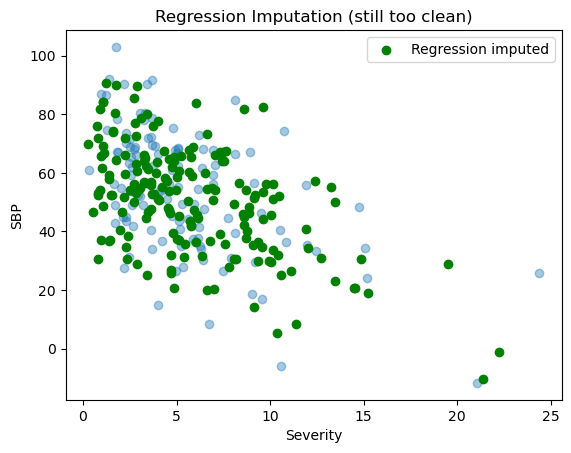

In [25]:
plt.figure()
plt.scatter(df_miss["Severity"], df_miss["SBP"], alpha=0.4)
plt.scatter(df_miss.loc[missing_mask, "Severity"],
            df_reg.loc[missing_mask, "SBP_imp"],
            color="green", label="Regression imputed")
plt.xlabel("Severity")
plt.ylabel("SBP")
plt.legend()
plt.title("Regression Imputation (still too clean)")
plt.show()

In [26]:
iter_imp = IterativeImputer(random_state=0)
df_iter = df_miss.copy()
df_iter["SBP_imp"] = iter_imp.fit_transform(df_miss)[ :,3]

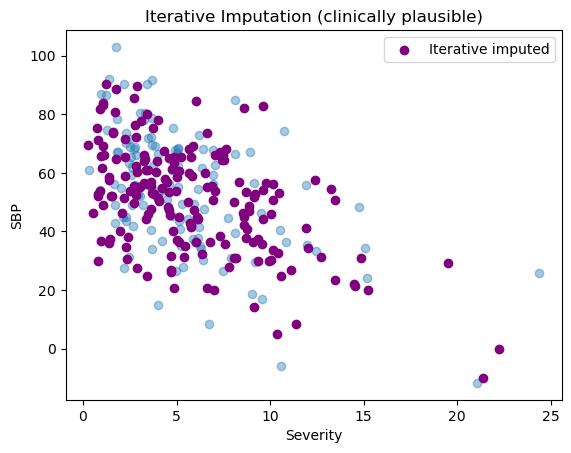

In [27]:
plt.figure()
plt.scatter(df_miss["Severity"], df_miss["SBP"], alpha=0.4)
plt.scatter(df_miss.loc[missing_mask, "Severity"],
            df_iter.loc[missing_mask, "SBP_imp"],
            color="purple", label="Iterative imputed")
plt.xlabel("Severity")
plt.ylabel("SBP")
plt.legend()
plt.title("Iterative Imputation (clinically plausible)")
plt.show()

In [38]:
true_sbp = df.loc[missing_mask,"SBP"]

def rmse(yhat):
    return np.sqrt(mean_squared_error(true_sbp, yhat))

print("Mean:", rmse(df_mean.loc[missing_mask, "SBP_imp"]))
print("Regression:", rmse(df_reg.loc[missing_mask, "SBP_imp"]))
print("Iterative:", rmse(df_iter.loc[missing_mask, "SBP_imp"]))

Mean: 20.770526374311014
Regression: 10.06488879862276
Iterative: 10.0372001617348
